# Artificial Neural Networks and Deep Learning  



## Assignment 3.2 - Convolutional Neural Networks

Prof. Dr. Ir. Johan A. K. Suykens     

In this file, we will implement a convolutional neural network from scratch.

We only consider classification tasks here in the session.




In [1]:
# Please first load your google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Please go to Edit > Notebook settings > Hardware accelerator > choose "T4 GPU"
# Now check if you have loaded the GPU successfully
# !nvidia-smi

# Convolutional Neural Networks
In this section, we implement CNN from scrath and train it on the MNIST dataset.

We first load the dataset as follows:

In [21]:
from pathlib import Path
import torch
from torch import nn, optim, functional, utils
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision import datasets, utils
from torchvision.datasets import MNIST
import pickle

import time, os

import matplotlib.pyplot as plt
# use seaborn
import seaborn as sns

FIGURE_PATH = Path("../report/figures")

# Apply the default theme
sns.set_theme()
plt.rcParams["figure.dpi"] = 100
plt.rcParams['savefig.dpi'] = 300

In [22]:
class Store:
	"""
	TODO: Add "default" parameter to function like a defaultdict
	TODO: Add "expected keys" property to iterate over (non-)missing keys
			- Could also be based on a pydantic model to define expected structure
	TODO: Add method to remove unexpected keys
	"""
	def __init__(self, filename):
		self.filename = filename
		self.data = {}
		if Path(filename).exists():
			with open(filename, 'rb') as f:
				self.data = pickle.load(f)
		else:
			with open(filename, 'wb') as f:
				pickle.dump(self.data, f)

	def __getitem__(self, key):
		return self.data[key]
	
	def __setitem__(self, key, value):
		self.data[key] = value
		with open(self.filename, 'wb') as f:
			pickle.dump(self.data, f)

	def __contains__(self, key):
		return key in self.data
	
	def __delitem__(self, key):
		del self.data[key]
		with open(self.filename, 'wb') as f:
			pickle.dump(self.data, f)

	def __iter__(self):
		return iter(self.data)
	
	def __len__(self):
		return len(self.data)
	
	def keys(self):
		return self.data.keys()
	
	def values(self):
		return self.data.values()
	
	def items(self):
		return self.data.items()
	
	def clear(self):
		self.data.clear()
		with open(self.filename, 'wb') as f:
			pickle.dump(self.data, f)

	def __str__(self):
		return str(self.data)
	
	def __repr__(self):
		return repr(self.data)
	
	def __del__(self):
		with open(self.filename, 'wb') as f:
			pickle.dump(self.data, f)

In [23]:
# Calculate the output of a convolution with the following 2x2 kernel with no padding and a stride
# of 2.
import numpy as np
from scipy.signal import convolve2d


matrix = np.array([[2, 5, 4, 1], [3, 1, 2, 0], [4, 5, 7, 1], [1, 2, 3, 4]])
kernel = np.array([[1, 0], [0, 1]])
output = convolve2d(matrix, kernel[::-1, ::-1], mode='valid')[::2, ::2]

print(output)


[[ 3  4]
 [ 6 11]]


In [10]:
def get_mnist_loader(batch_size=100, num_train_samples = 10000, num_test_samples = 2000):
    """

    :return: train_loader, test_loader
    """
    train_dataset = MNIST(root='./data',
                          train=True,
                          transform=torchvision.transforms.ToTensor(),
                          download=True)
    test_dataset = MNIST(root='./data',
                         train=False,
                         transform=torchvision.transforms.ToTensor(),
                         download=True)

    # Randomly select a subset of samples
    train_indices = torch.randperm(len(train_dataset))[:num_train_samples]
    test_indices = torch.randperm(len(test_dataset))[:num_test_samples]

    # Create subset samplers to be used in the dataloader
    train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               sampler = train_subset_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              sampler = test_subset_sampler)


    return train_loader, test_loader

## Build CNN from scratch
Our CNN is of 4 convolutional layers and 2 fully connected layers.
You can try a different amount of layers by simply add more ``self.conv`` layers inside  ``__init__`` and ``forward`` in the following code. Please be careful with the dimensions of the convolutional layers when changing parameters such as convolution channels, kernel_size and stride.

## Training function
The training process includes loading the model, setting the optimizer, and running on the training set for epochs.
After each training epoch, we evaluate the model on the test set to record the test accuracy.

In [55]:
def train(model, train_epoch, model_save, train_loader, test_loader) :
    # Push model on to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    loss_func = nn.CrossEntropyLoss( )
    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters( ),lr=0.001)

    acc_count = []  # record the test accuracy
    for epoch in range(train_epoch):

        model.train()

        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)  # torch,Size([128,1,28,28])
            y = y.to(device)   # torch.Size([128])
            # Output of the model
            out = model(x)  # torch.Size([128,10])
            # Compute loss
            loss = loss_func(out, y)

            optimizer.zero_grad()
            loss.backward()  # backpropagation
            optimizer.step()  # update the network parameters

            # save the model checkpoint every 20 iterations
            if i % 20 == 0:
                print('Training Loss:{:.6f} Batch {}/{} '.format(loss.item(), i, len(train_loader)))
                torch.save(model, model_save)

        # evaluate the model after each training epoch
        with torch.no_grad():
            model.eval()

            true_pred = torch.zeros(1).to(device)
            nb_sample = 0

            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                _, pred = torch.max(outputs, dim=1)

                true_pred = true_pred + torch.sum(pred == targets).type(torch.FloatTensor)
                nb_sample += len(inputs)

            acc = true_pred / nb_sample
            acc = acc.item()

            acc_count.append(acc)

            print('Epoch {:d}, Test Accuracy {:.3f} %'.format(epoch, acc * 100))

    return acc_count

## Let's start training!
The network is trained for 20 epochs, batch size of 100.

You can adjust the hyperparameters here if necessary.

In [56]:
# You can adjust the hyperparameters here if needed
train_epoch = 20
batch_size = 100
shuffle = True

# where to save the model
model_save = './models/MNIST_CNN/ckpt.pth'

import os
if not os.path.exists('./models/MNIST_CNN'):
    os.mkdir('./models/MNIST_CNN')

In [57]:
# load datasets
train_loader, test_loader = get_mnist_loader(batch_size=batch_size)

print("Shape of the image batch: ", next(iter(train_loader))[0].shape)
store = Store("acc_count.pkl")

Shape of the image batch:  torch.Size([100, 1, 28, 28])


In [268]:
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            # 2-D convolution
            torch.nn.Conv2d(in_channels=1, # input channels
                            out_channels=32, # convolution channels
                            kernel_size=4, # kernel size of the convolution
                            stride=2, # stride of the kernel
                            padding=2), # padding with 0
            # Data is normalized before entering ReLU，num_features=batch_size*num_features*height*width
            # Output is with size (N,C,W,H), i.e., (batch_size, channels, width, height)
            torch.nn.BatchNorm2d(32), # the input dimensionality of BatchNorm2d should match the number of convolution channels
            # Set activation function
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            # torch.nn.MaxPool2d(2, 2),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,4,2,1), # be sure to have the number of input channels match the output channels of the previous layer
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.4),
            # torch.nn.MaxPool2d(2, 2),
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,3,1,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.4),
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,1,0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            # torch.nn.MaxPool2d(2,2),
            # torch.nn.Dropout(0.4)
        )
        # set fully connected layer
        self.mlp1 = torch.nn.Linear(2304, 100) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100, 10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x

In [269]:
# Define model
model = CNNnet()

# train the model
acc_count = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)
store["acc_count"] = acc_count

Training Loss:2.332529 Batch 0/100 
Training Loss:0.889077 Batch 20/100 
Training Loss:0.500799 Batch 40/100 
Training Loss:0.397503 Batch 60/100 
Training Loss:0.392155 Batch 80/100 
Epoch 0, Test Accuracy 94.150 %
Training Loss:0.422666 Batch 0/100 
Training Loss:0.150731 Batch 20/100 
Training Loss:0.305067 Batch 40/100 
Training Loss:0.358096 Batch 60/100 
Training Loss:0.347450 Batch 80/100 
Epoch 1, Test Accuracy 95.550 %
Training Loss:0.158108 Batch 0/100 
Training Loss:0.170049 Batch 20/100 
Training Loss:0.054528 Batch 40/100 
Training Loss:0.166135 Batch 60/100 
Training Loss:0.201642 Batch 80/100 
Epoch 2, Test Accuracy 97.150 %
Training Loss:0.099589 Batch 0/100 
Training Loss:0.183816 Batch 20/100 
Training Loss:0.180226 Batch 40/100 
Training Loss:0.253212 Batch 60/100 
Training Loss:0.081286 Batch 80/100 
Epoch 3, Test Accuracy 97.100 %
Training Loss:0.146281 Batch 0/100 
Training Loss:0.215650 Batch 20/100 
Training Loss:0.136270 Batch 40/100 
Training Loss:0.123437 Bat

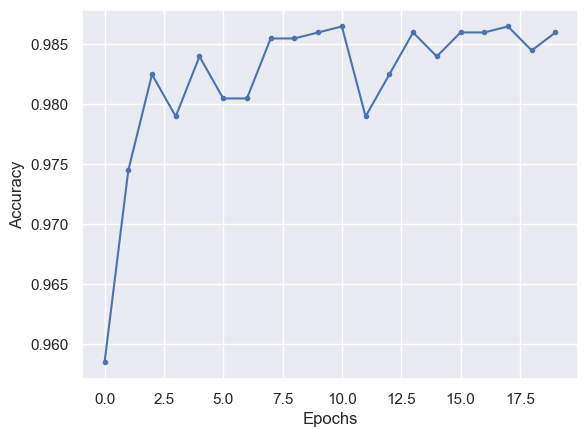

In [263]:
# Plot the accuracy curves w.r.t. epochs
acc_count = store["acc_count"]
plt.figure()
plt.plot(acc_count, marker='.')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
# plt.title('Test Accuracy of CNN')
plt.savefig(FIGURE_PATH / "ex3_2_accuracy.pdf", bbox_inches='tight')
plt.show()

In [245]:
# Load the model
model = torch.load(model_save)

# Evaluate the model
with torch.no_grad():
    model.eval()

    true_pred = torch.zeros(1)
    nb_sample = 0

    for inputs, targets in test_loader:
        outputs = model(inputs)

        _, pred = torch.max(outputs, dim=1)

        true_pred = true_pred + torch.sum(pred == targets).type(torch.FloatTensor)
        nb_sample += len(inputs)

    acc = true_pred / nb_sample
    acc = acc.item()

    print('Test Accuracy {:.3f}%'.format(acc * 100))

Test Accuracy 98.850%


In [246]:
model

CNNnet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mlp1): Linear(in_features=2304, out_features=100, bias=True)
